In [153]:
### Paso 1. Librerías

import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import re

In [154]:
### Paso 2. Conectarse Url

url_search_location = "https://tripadvisor16.p.rapidapi.com/api/v1/restaurant/searchLocation"
url_search_restaurants = "https://tripadvisor16.p.rapidapi.com/api/v1/restaurant/searchRestaurants"
url_restaurant_details = "https://tripadvisor16.p.rapidapi.com/api/v1/restaurant/getRestaurantDetails"

querystring = {"locationId":"60763"}
headers = {
	"x-rapidapi-key": "0222e1841fmsh962880997234635p1bbc18jsne39fac371f87",
	"x-rapidapi-host": "tripadvisor16.p.rapidapi.com"
}

MAX_PAGINAS = 44   
SLEEP_SECONDS = 1
CURRENCY = "USD"

In [155]:
### Paso 3. Funciones

def buscar_location_id_manhattan():
    """
    Encuentra el locationId de Manhattan.
    """
    params = {"query": "Manhattan, New York"}
    r = requests.get(url_search_location, headers=headers, params=params)

    if r.status_code != 200:
        print(f"❌ Error searchLocation | status={r.status_code}")
        return None

    data = r.json()
    resultados = data.get("data", [])

    if not isinstance(resultados, list) or len(resultados) == 0:
        print("⚠️ No se encontró ningún resultado para Manhattan.")
        return None

    loc_id = resultados[0].get("locationId")
    print("✅ locationId Manhattan:", loc_id)
    return loc_id


def obtener_restaurantes_por_pagina(location_id, page=1):
    """
    Obtiene restaurantes de Manhattan por página (searchRestaurants).
    Retorna lista de dicts.
    """
    params = {
        "locationId": str(location_id),
        "page": page,
        "currencyCode": CURRENCY
    }

    r = requests.get(url_search_restaurants, headers=headers, params=params)

    if r.status_code != 200:
        print(f"❌ Error searchRestaurants | page={page} | status={r.status_code}")
        return []

    data = r.json()
    contenedor = data.get("data", {})
    lista = contenedor.get("data", [])

    if not isinstance(lista, list):
        return []

    # devolver solo dicts válidos
    return [x for x in lista if isinstance(x, dict)]


def obtener_detalles_restaurante(location_id_rest):
    """
    Obtiene detalles del restaurante (getRestaurantDetails).
    Retorna dict.
    NOTA: este endpoint normalmente NO trae review text.
    """
    params = {
        "locationId": str(location_id_rest),
        "currencyCode": CURRENCY
    }

    r = requests.get(url_restaurant_details, headers=headers, params=params)

    if r.status_code != 200:
        return None

    data = r.json()
    detalles = data.get("data", None)

    if not isinstance(detalles, dict):
        return None

    return detalles


# ✅ NUEVO: cocina desde searchRestaurants (establishmentTypeAndCuisineTags)
def extraer_cocinas(obj):
    """
    Cocina / tipo cocina suele venir como lista de strings:
    establishmentTypeAndCuisineTags = ["Italian", "Steakhouse", ...]
    """
    if not obj or not isinstance(obj, dict):
        return None

    tags = obj.get("establishmentTypeAndCuisineTags")
    if isinstance(tags, list) and len(tags) > 0:
        # lista de strings
        return ", ".join([t for t in tags if isinstance(t, str) and t.strip()])

    return None


# ✅ NUEVO: reseña cualitativa desde searchRestaurants (reviewSnippets)
def extraer_resena_cualitativa_desde_search(r):
    """
    Extrae snippets cualitativos desde searchRestaurants:
    reviewSnippets -> reviewSnippetsList -> reviewText
    """
    if not isinstance(r, dict):
        return None

    review_snippets = r.get("reviewSnippets", {})
    if not isinstance(review_snippets, dict):
        return None

    lista = review_snippets.get("reviewSnippetsList", [])
    if not isinstance(lista, list) or len(lista) == 0:
        return None

    textos = []
    for s in lista:
        if isinstance(s, dict):
            t = s.get("reviewText")
            if isinstance(t, str) and t.strip():
                textos.append(t.strip())

    if len(textos) == 0:
        return None

    # Si querés SOLO 1 reseña, usá: return textos[0]
    return " | ".join(textos)



In [156]:
## Paso 4. Extracción de datos

def extraer_manhattan_variables_clave():
    manhattan_id = buscar_location_id_manhattan()
    if not manhattan_id:
        print("⛔ No se pudo obtener el locationId de Manhattan.")
        return pd.DataFrame()

    filas = []
    vistos = set()

    for page in range(1, MAX_PAGINAS + 1):
        print(f"\n📄 Extrayendo página {page}/{MAX_PAGINAS}...")

        restaurantes = obtener_restaurantes_por_pagina(manhattan_id, page=page)

        if len(restaurantes) == 0:
            print("✅ No hay resultados en esta página. Fin.")
            break

        print(f"🍽️ Restaurantes encontrados en página {page}: {len(restaurantes)}")

        for r in restaurantes:
            rest_id = r.get("locationId")
            if not rest_id:
                continue

            if rest_id in vistos:
                continue
            vistos.add(rest_id)

            # -------- variables base (searchRestaurants) --------
            nombre = r.get("name")
            rating = r.get("averageRating")
            user_review_count = r.get("userReviewCount")
            precio = r.get("priceTag")

            # ✅ cocina desde searchRestaurants
            cocina = extraer_cocinas(r)

            # ✅ reseña cualitativa desde searchRestaurants
            resena_cualitativa = extraer_resena_cualitativa_desde_search(r)

            # (opcional) mantener detalles si en algún momento lo necesitás
            # detalles = obtener_detalles_restaurante(rest_id)

            filas.append({
                "restaurant_name": nombre,
                "rating": rating,
                "numero_resenas": user_review_count,
                "price": precio,
                "cocina": cocina,
                "resena_cualitativa": resena_cualitativa,
                "userReviewCount": user_review_count
            })

            time.sleep(SLEEP_SECONDS)

        time.sleep(SLEEP_SECONDS)

    df = pd.DataFrame(filas)

    print("\n✅ Extracción finalizada.")
    print("✅ Filas:", df.shape[0])
    print("✅ Columnas:", df.shape[1])

    return df

In [23]:
## Paso 5. Ejecución 

df_manhattan = extraer_manhattan_variables_clave()

✅ locationId Manhattan: 60763

📄 Extrayendo página 1/44...
🍽️ Restaurantes encontrados en página 1: 34

📄 Extrayendo página 2/44...
🍽️ Restaurantes encontrados en página 2: 35

📄 Extrayendo página 3/44...
🍽️ Restaurantes encontrados en página 3: 35

📄 Extrayendo página 4/44...
🍽️ Restaurantes encontrados en página 4: 35

📄 Extrayendo página 5/44...
🍽️ Restaurantes encontrados en página 5: 35

📄 Extrayendo página 6/44...
🍽️ Restaurantes encontrados en página 6: 35

📄 Extrayendo página 7/44...
🍽️ Restaurantes encontrados en página 7: 35

📄 Extrayendo página 8/44...
🍽️ Restaurantes encontrados en página 8: 35

📄 Extrayendo página 9/44...
🍽️ Restaurantes encontrados en página 9: 35

📄 Extrayendo página 10/44...
🍽️ Restaurantes encontrados en página 10: 35

📄 Extrayendo página 11/44...
🍽️ Restaurantes encontrados en página 11: 35

📄 Extrayendo página 12/44...
🍽️ Restaurantes encontrados en página 12: 35

📄 Extrayendo página 13/44...
🍽️ Restaurantes encontrados en página 13: 35

📄 Extrayendo

In [173]:
### Paso 6. Selección de las variables (columnas) importantes para el proyecto

# 1. Selección de las variables (columnas) importantes para el proyecto

lista_columnas_restaurantes = [
    "restaurant_name",       # Nombre del restaurante
    "rating",                # Rating promedio
    "numero_resenas",        # Cantidad de reseñas
    "price",                 # Rango de precio
    "cocina",                # Tipo de cocina
    "resena_cualitativa"     # Reseña cualitativa
]

try:
    # ✅ (Opcional) Si tu columna viniera como "Restaurant_Name", la estandarizamos
    if "Restaurant_Name" in df_manhattan.columns:
        df_manhattan = df_manhattan.rename(columns={"Restaurant_Name": "restaurant_name"})

# 2. Creación del dataset de las columnas seleccionadas
    
    df_manhattan_limpio = df_manhattan[lista_columnas_restaurantes].copy()

# 3. Renombre de las columnas seleccionadas
    
    df_manhattan_limpio = df_manhattan_limpio.rename(columns={
        "restaurant_name": "Nombre_Restaurante",
        "rating": "Rating",
        "numero_resenas": "Cantidad_Reseñas",
        "price": "Precio",
        "cocina": "Tipo_Cocina",
        "resena_cualitativa": "Resena"
    })

    # ✅ Verificar resultado
    print("✅ DataFrame limpio creado correctamente")
    print(df_manhattan_limpio.head())

except KeyError as e:
    print("❌ Error: Hay columnas que no existen en df_manhattan.")
    print("Detalle:", e)
    print("\n📌 Columnas disponibles:")
    print(df_manhattan.columns.tolist())

nombre_archivo = "df_manhattan_limpio.csv"
df_manhattan_limpio.to_csv(nombre_archivo, index=False, encoding="utf-8")
ruta_completa = os.path.abspath(nombre_archivo)
print("✅ Archivo guardado en esta ruta:")
print(ruta_completa)
df_manhattan_limpio

✅ DataFrame limpio creado correctamente
            Nombre_Restaurante  Rating  Cantidad_Reseñas    Precio  \
0  Drai's Supper Club New York     5.0                 1      $$$$   
1               Sea Fire Grill     4.4              1184      $$$$   
2       Boucherie West Village     4.8              2401  $$ - $$$   
3    Piccola Cucina Estiatorio     4.8              1210  $$ - $$$   
4       Piccola Cucina Osteria     4.7              3538  $$ - $$$   

           Tipo_Cocina                                             Resena  
0     French, American                         Amazing place recommend!!!  
1  Steakhouse, Seafood  The ￹salmon￻ was prepared exactly as requested...  
2               French  ￹Salmon￻ was perfectly tender and flaky. | Ama...  
3    Italian, Sicilian  Perfectly located in the heart of soho I can h...  
4    Italian, Sicilian  We had the lasagna and ￹risotto￻ and both dish...  
✅ Archivo guardado en esta ruta:
C:\Users\ecarm\OneDrive\Escritorio\Educación Tebi\

,Nombre_Restaurante,Rating,Cantidad_Reseñas,Precio,Tipo_Cocina,Resena
0,Drai's Supper Club New York,5.0,1,$$$$,"French, American",Amazing place recommend!!!
1,Sea Fire Grill,4.4,1184,$$$$,"Steakhouse, Seafood",The ￹salmon￻ was prepared exactly as requested...
2,Boucherie West Village,4.8,2401,$$ - $$$,French,￹Salmon￻ was perfectly tender and flaky. | Ama...
3,Piccola Cucina Estiatorio,4.8,1210,$$ - $$$,"Italian, Sicilian",Perfectly located in the heart of soho I can h...
4,Piccola Cucina Osteria,4.7,3538,$$ - $$$,"Italian, Sicilian",We had the lasagna and ￹risotto￻ and both dish...
...,...,...,...,...,...,...
1286,Attaboy Cocktail Bar,-1.0,0,None,"Bar, Pub",None
1287,Tacoshi,-1.0,0,None,"Latin, Spanish, Asian",None
1288,El Coyote Forest Hills,-1.0,0,None,Mexican,None
1289,Deja Vu New York,-1.0,0,None,None,None


In [174]:
### Paso 7. ESTANDARIZACIÓN Y CONVERSIÓN DE TIPOS DE DATOS

# 1. Normalizar precio

def normalizar_precio(valor):
    """
    Convierte:
    '$$$$' -> 4
    '$$ - $$$' -> 2.5
    '$$ - $$' -> 2
    None / '-' -> NaN
    """
    if pd.isna(valor):
        return None
    
    texto = str(valor).strip()

    if texto.lower() in ["none", "nan", "-", "—", ""]:
        return None

    # Extrae grupos de "$" dentro del texto
    grupos = re.findall(r"\$+", texto)

    if len(grupos) == 0:
        return None

    # Si solo hay un grupo: "$$$$"
    if len(grupos) == 1:
        return len(grupos[0])

    # Si hay dos grupos: "$$ - $$$"
    if len(grupos) >= 2:
        min_p = len(grupos[0])
        max_p = len(grupos[1])
        return (min_p + max_p) / 2

def categorizar_precio(valor):
    """
    Convierte:
    1   -> Bajo
    2   -> Medio
    3   -> Alto
    4   -> Muy Alto
    (incluye rangos como 2.5)
    """
    if pd.isna(valor):
        return "No disponible"
    elif valor <= 1.5:
        return "Bajo"
    elif valor <= 2.5:
        return "Medio"
    elif valor <= 3.5:
        return "Alto"
    else:
        return "Muy Alto"

# 2. Normalizar Tipo_Cocina

def normalizar_tipo_cocina(texto):
    """
    Limpia cocina:
    - minúsculas
    - elimina espacios dobles
    - quita duplicados
    """
    if pd.isna(texto):
        return None

    texto = str(texto).strip()

    if texto in ["None", "-", "—", ""]:
        return None

    items = [x.strip().lower() for x in texto.split(",") if x.strip() != ""]
    items_unicos = list(dict.fromkeys(items))  # elimina duplicados manteniendo orden

    return ", ".join(items_unicos)

# 3. Normalizar Reseña

def normalizar_resena(texto):
    """
    Limpia reseña:
    - elimina caracteres raros tipo ￹ ￻
    - elimina saltos de línea
    - elimina espacios dobles
    """
    if pd.isna(texto):
        return None

    texto = str(texto).strip()

    if texto in ["None", "-", "—", ""]:
        return None

    # Eliminar caracteres extraños como ￹ ￻
    texto = re.sub(r"[￹￻]", "", texto)

    # Eliminar saltos de línea
    texto = texto.replace("\n", " ").replace("\r", " ")

    # Quitar espacios dobles
    texto = re.sub(r"\s+", " ", texto).strip()

    return texto
   

# 4. Aplicar Funciones

df_manhattan_limpio["Precio"] = df_manhattan_limpio["Precio"].apply(normalizar_precio)
df_manhattan_limpio["Precio"] = df_manhattan_limpio["Precio"].apply(categorizar_precio)
df_manhattan_limpio["Tipo_Cocina"] = df_manhattan_limpio["Tipo_Cocina"].apply(normalizar_tipo_cocina)
df_manhattan_limpio["Resena"] = df_manhattan_limpio["Resena"].apply(normalizar_resena)

# 5. ✅ Ver resultado

print("✅ Columnas finales del dataframe:")
print(df_manhattan_limpio.columns.tolist())

print("\n✅ Muestra del dataframe normalizado:")
print(df_manhattan_limpio.head(10))

print("\n✅ Distribución final de Precio (categorías):")
print(df_manhattan_limpio["Precio"].value_counts())

df_manhattan_limpio = df_manhattan_limpio.drop(
    columns=["Precio_Normalizado", "Tipo_Cocina_Normalizada", "Resena_Normalizada"],
    errors="ignore"
)
print("✅ Columnas eliminadas (si existían).")
print(df_manhattan_limpio.columns.tolist())
df_manhattan_limpio

✅ Columnas finales del dataframe:
['Nombre_Restaurante', 'Rating', 'Cantidad_Reseñas', 'Precio', 'Tipo_Cocina', 'Resena']

✅ Muestra del dataframe normalizado:
            Nombre_Restaurante  Rating  Cantidad_Reseñas    Precio  \
0  Drai's Supper Club New York     5.0                 1  Muy Alto   
1               Sea Fire Grill     4.4              1184  Muy Alto   
2       Boucherie West Village     4.8              2401     Medio   
3    Piccola Cucina Estiatorio     4.8              1210     Medio   
4       Piccola Cucina Osteria     4.7              3538     Medio   
5            Club A Steakhouse     4.7              4706  Muy Alto   
6               Sicily Osteria     4.8              1617     Medio   
7         Em Vietnamese Bistro     4.6                32     Medio   
8                   Olio E Più     4.7              3931     Medio   
9                  Dos Caminos     4.5              2152     Medio   

                         Tipo_Cocina  \
0                   french, a

,Nombre_Restaurante,Rating,Cantidad_Reseñas,Precio,Tipo_Cocina,Resena
0,Drai's Supper Club New York,5.0,1,Muy Alto,"french, american",Amazing place recommend!!!
1,Sea Fire Grill,4.4,1184,Muy Alto,"steakhouse, seafood",The salmon was prepared exactly as requested a...
2,Boucherie West Village,4.8,2401,Medio,french,Salmon was perfectly tender and flaky. | Amazi...
3,Piccola Cucina Estiatorio,4.8,1210,Medio,"italian, sicilian",Perfectly located in the heart of soho I can h...
4,Piccola Cucina Osteria,4.7,3538,Medio,"italian, sicilian",We had the lasagna and risotto and both dishes...
...,...,...,...,...,...,...
1286,Attaboy Cocktail Bar,-1.0,0,No disponible,"bar, pub",None
1287,Tacoshi,-1.0,0,No disponible,"latin, spanish, asian",None
1288,El Coyote Forest Hills,-1.0,0,No disponible,mexican,None
1289,Deja Vu New York,-1.0,0,No disponible,None,None


In [175]:
### Paso 8. Limpieza de datos nulos y duplicados

#1. Limpieza de filas con datos nulos

df_manhattan_sin_nulos = df_manhattan_limpio.dropna(subset=["Tipo_Cocina", "Resena"]).copy()

print("✅ Shape original:", df_manhattan_limpio.shape)
print("✅ Shape sin nulos:", df_manhattan_sin_nulos.shape)

print("\n✅ Nulos por columna en df_manhattan_sin_nulos:\n")
print(df_manhattan_sin_nulos.isnull().sum())

#2. Revisar Duplicados y repetidos

duplicados_exactos = df_manhattan_sin_nulos.duplicated().sum()
print("\n🔁 Filas duplicadas exactas (idénticas):", duplicados_exactos)

df_manhattan_sin_nulos = df_manhattan_sin_nulos.drop_duplicates().copy()
print("✅ Shape después de eliminar duplicados exactos:", df_manhattan_sin_nulos.shape)

#3. Revisar restaurantes repetidos por nombre

repetidos_nombre = df_manhattan_sin_nulos["Nombre_Restaurante"].duplicated().sum()
print("\n🍽️ Restaurantes repetidos por Nombre_Restaurante:", repetidos_nombre)

print("\n📌 Top 20 restaurantes más repetidos:\n")
print(df_manhattan_sin_nulos["Nombre_Restaurante"].value_counts().head(20))

df_repetidos_detalle = df_manhattan_sin_nulos[
    df_manhattan_sin_nulos["Nombre_Restaurante"].duplicated(keep=False)
].sort_values("Nombre_Restaurante")

print("\n🔎 Ejemplo de registros repetidos (primeros 20):\n")
print(df_repetidos_detalle.head(20))

df_manhattan_unicos = df_manhattan_sin_nulos.sort_values(
    by=["Nombre_Restaurante", "Rating", "Cantidad_Reseñas"],
    ascending=[True, False, False]
).drop_duplicates(subset=["Nombre_Restaurante"], keep="first").copy()

print("\n✅ Shape final sin repetidos por nombre:", df_manhattan_unicos.shape)

# Mostrar el dataframe final limpio
df_manhattan_unicos

✅ Shape original: (1291, 6)
✅ Shape sin nulos: (1217, 6)

✅ Nulos por columna en df_manhattan_sin_nulos:

Nombre_Restaurante    0
Rating                0
Cantidad_Reseñas      0
Precio                0
Tipo_Cocina           0
Resena                0
dtype: int64

🔁 Filas duplicadas exactas (idénticas): 0
✅ Shape después de eliminar duplicados exactos: (1217, 6)

🍽️ Restaurantes repetidos por Nombre_Restaurante: 51

📌 Top 20 restaurantes más repetidos:

Nombre_Restaurante
Le Pain Quotidien            7
The Smith                    4
Pret A Manger                4
Whole Foods Market           4
Five Guys                    4
The Capital Grille           3
Wolfgang's Steakhouse        3
Artichoke Basille's Pizza    3
Friedman's                   3
Rosa Mexicano                2
Levain Bakery                2
Spice Symphony               2
Jackson Hole Burgers         2
Totto Ramen                  2
Tacombi                      2
STK Steakhouse               2
RedFarm                     

,Nombre_Restaurante,Rating,Cantidad_Reseñas,Precio,Tipo_Cocina,Resena
317,$1.50 Fresh Pizza,4.3,341,Bajo,"pizza, fast food",If you are in New York make sure to stop... | ...
858,12 Chairs,4.3,285,Medio,"mediterranean, middle eastern, israeli","... couscous, hummus, pita, bsba ganoush, labn..."
466,15 EAST @ Tocqueville,4.4,451,Muy Alto,"french, japanese, sushi, asian",Appetizers were lovely and sushi was fine craf...
1103,1803 NYC,4.4,83,Medio,"american, cajun & creole",We really enjoyed 1803. We recently visited Ne...
509,2 Bros Pizza,4.4,269,Bajo,"italian, american, pizza, fast food",A small hole in the wall New York style pizza ...
...,...,...,...,...,...,...
533,limani,4.2,452,Muy Alto,"seafood, greek",The grilled shrimp appetizer was delicious as ...
808,maman,4.3,201,Medio,cafe,Don't miss their quiche - divine! | The combo ...
591,miss Korea BBQ,4.0,668,Medio,"barbecue, korean, contemporary",We liked the beef combo A and the bibimbap. | ...
72,ofCorsica!,5.0,1,Muy Alto,"seafood, mediterranean, healthy",Very cool spot and great food


✅ Shape: (1166, 6)

✅ Tipos de datos:

Nombre_Restaurante     object
Rating                float64
Cantidad_Reseñas        int64
Precio                 object
Tipo_Cocina            object
Resena                 object
dtype: object

✅ Nulos por columna:

Nombre_Restaurante    0
Rating                0
Cantidad_Reseñas      0
Precio                0
Tipo_Cocina           0
Resena                0
dtype: int64

✅ Filas duplicadas exactas: 0

📊 Estadística descriptiva (Rating y Cantidad_Reseñas):

            Rating  Cantidad_Reseñas
count  1166.000000       1166.000000
mean      4.288851        640.265866
std       0.289405       1333.770331
min       1.500000          1.000000
25%       4.100000        143.250000
50%       4.300000        298.000000
75%       4.400000        657.500000
max       5.000000      23592.000000


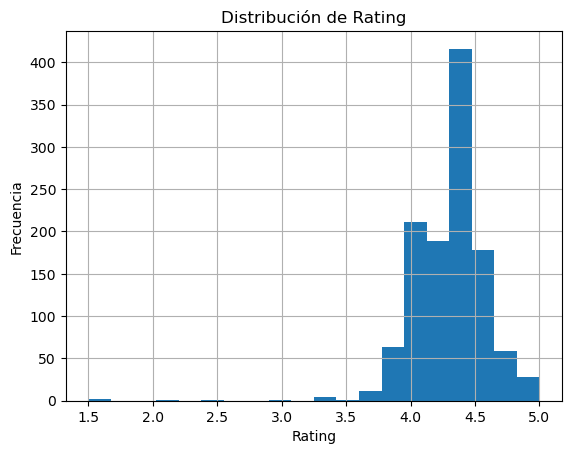

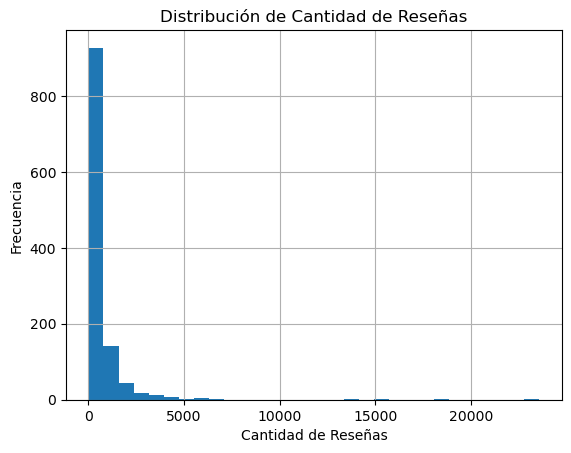

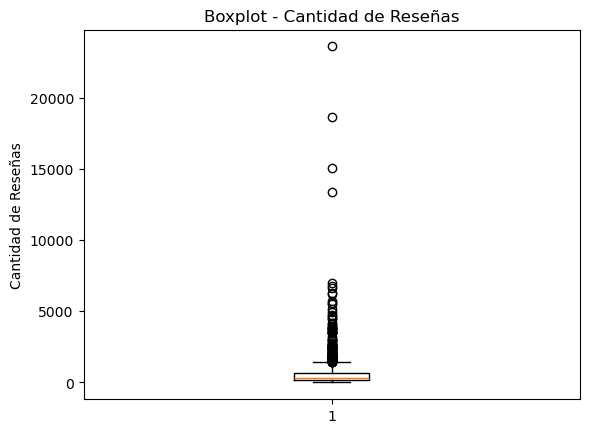

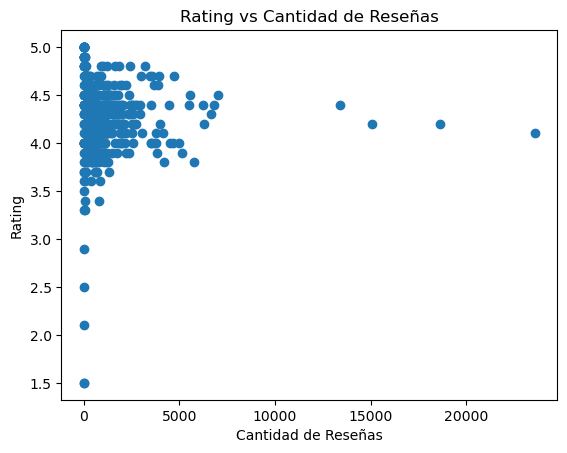


💲 Frecuencia de Precio:

Precio
Medio            812
Muy Alto         197
Bajo             127
No disponible     30
Name: count, dtype: int64

💲 Porcentaje de Precio (%):

Precio
Medio            69.64
Muy Alto         16.90
Bajo             10.89
No disponible     2.57
Name: proportion, dtype: float64

⭐ Rating promedio por categoría de Precio:

Precio
Bajo             4.334646
Muy Alto         4.302538
Medio            4.279557
No disponible    4.256667
Name: Rating, dtype: float64

🧾 Cantidad de reseñas promedio por categoría de Precio:

Precio
Muy Alto         918.959391
Medio            626.298030
Bajo             447.740157
No disponible      3.266667
Name: Cantidad_Reseñas, dtype: float64

🏆 Top 10 restaurantes por Rating (mínimo 50 reseñas):

                Nombre_Restaurante  Rating  Cantidad_Reseñas    Precio  \
54                 El Coco 9th Ave     4.9                78  Muy Alto   
81                     A.R.T. SoHo     4.9                62     Medio   
13   Bua Thai Ra

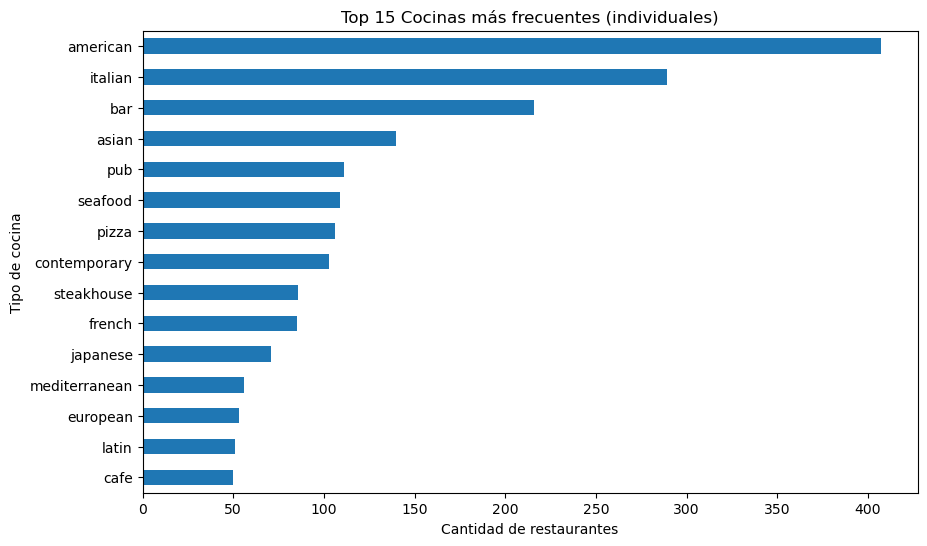

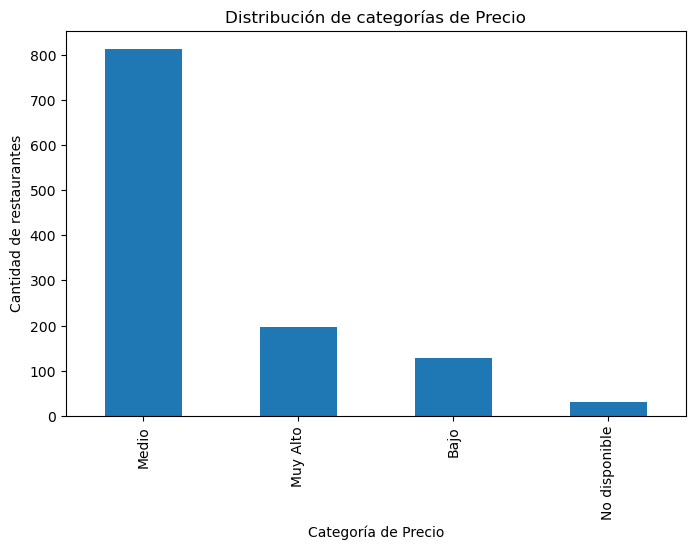

C:\Users\ecarm\AppData\Local\Temp\ipykernel_18628\287075586.py:137: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categorias)


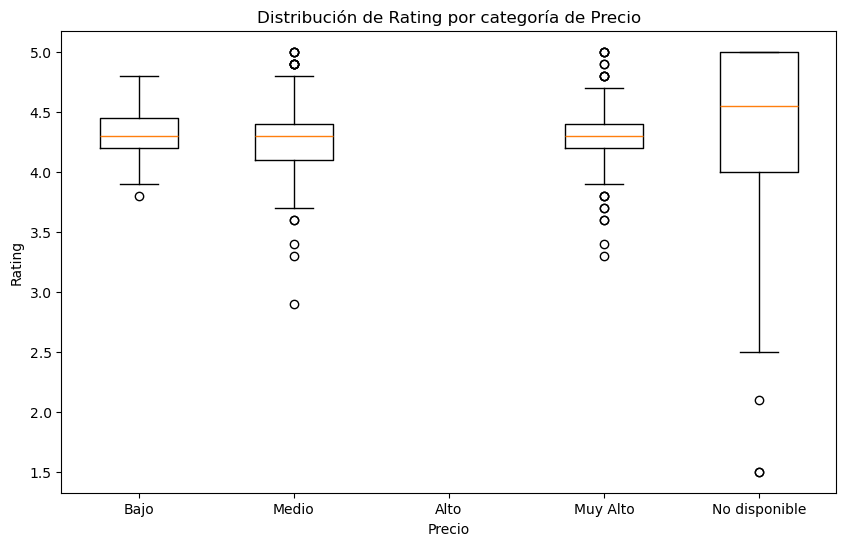

C:\Users\ecarm\AppData\Local\Temp\ipykernel_18628\287075586.py:148: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categorias, showfliers=False)  # sin outliers extremos


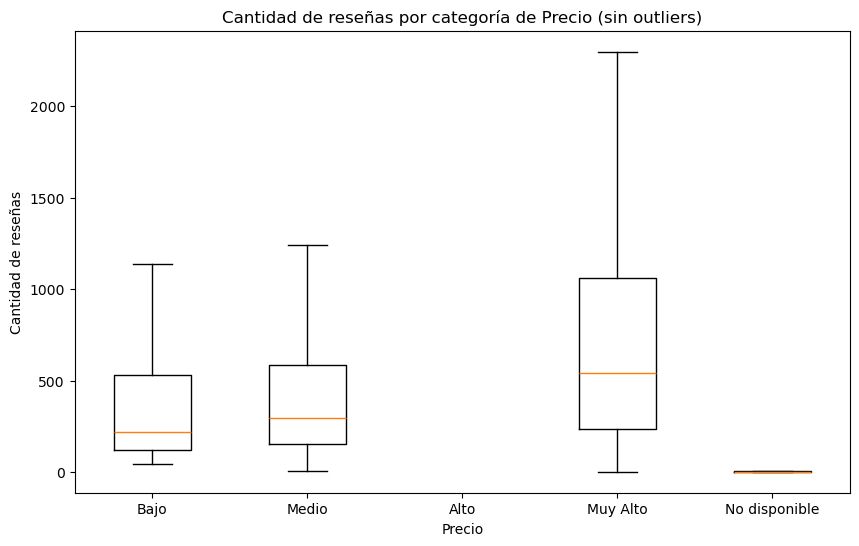

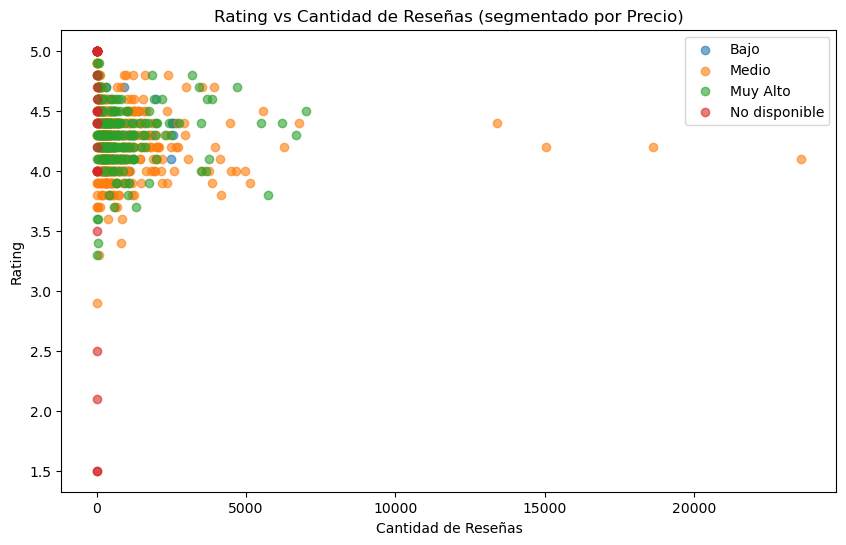

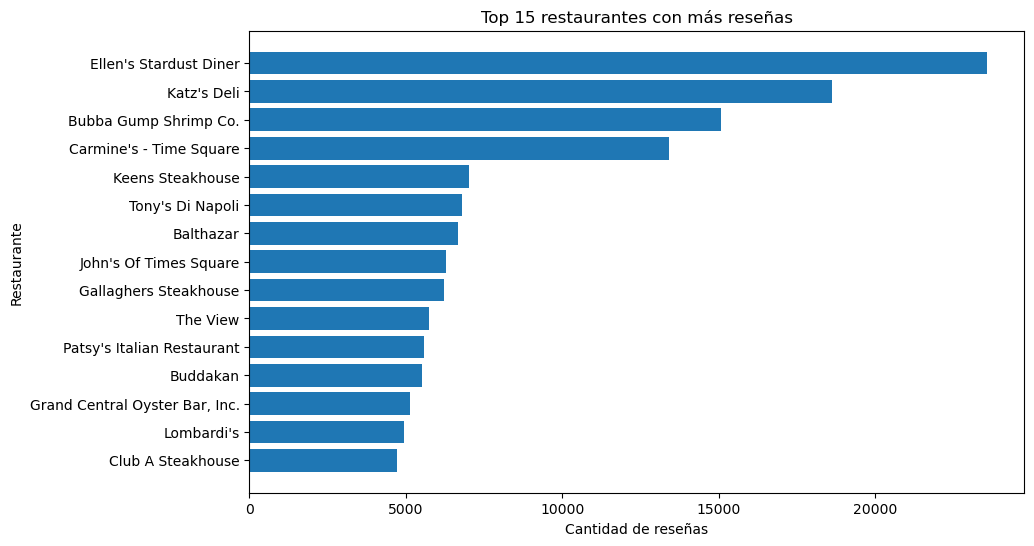

In [176]:
### Paso 9. Análisis exploratorio de datos (EDA)

#1. Vista general del datase

print("✅ Shape:", df_manhattan_unicos.shape)
print("\n✅ Tipos de datos:\n")
print(df_manhattan_unicos.dtypes)
print("\n✅ Nulos por columna:\n")
print(df_manhattan_unicos.isnull().sum())
print("\n✅ Filas duplicadas exactas:", df_manhattan_unicos.duplicated().sum())

#2. Estadística descriptiva (variables numéricas)

print("\n📊 Estadística descriptiva (Rating y Cantidad_Reseñas):\n")
print(df_manhattan_unicos[["Rating", "Cantidad_Reseñas"]].describe())

#3. Distribución de rating

plt.figure()
df_manhattan_unicos["Rating"].hist(bins=20)
plt.title("Distribución de Rating")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

#4. Distribución de cantidad de reseñas

plt.figure()
df_manhattan_unicos["Cantidad_Reseñas"].hist(bins=30)
plt.title("Distribución de Cantidad de Reseñas")
plt.xlabel("Cantidad de Reseñas")
plt.ylabel("Frecuencia")
plt.show()

#5. Boxplot para detectar outliers (cantidad de reseñas)

plt.figure()
plt.boxplot(df_manhattan_unicos["Cantidad_Reseñas"])
plt.title("Boxplot - Cantidad de Reseñas")
plt.ylabel("Cantidad de Reseñas")
plt.show()

#6. Correlación Rating vs Cantidad_Reseñas (scatter)

plt.figure()
plt.scatter(df_manhattan_unicos["Cantidad_Reseñas"], df_manhattan_unicos["Rating"])
plt.title("Rating vs Cantidad de Reseñas")
plt.xlabel("Cantidad de Reseñas")
plt.ylabel("Rating")
plt.show()

#7. Estadística de Precio (categorías)

print("\n💲 Frecuencia de Precio:\n")
print(df_manhattan_unicos["Precio"].value_counts())

print("\n💲 Porcentaje de Precio (%):\n")
print((df_manhattan_unicos["Precio"].value_counts(normalize=True) * 100).round(2))

#8. Rating promedio por Precio

rating_por_precio = df_manhattan_unicos.groupby("Precio")["Rating"].mean().sort_values(ascending=False)
print("\n⭐ Rating promedio por categoría de Precio:\n")
print(rating_por_precio)

#9. Cantidad de reseñas promedio por Precio

resenas_por_precio = df_manhattan_unicos.groupby("Precio")["Cantidad_Reseñas"].mean().sort_values(ascending=False)
print("\n🧾 Cantidad de reseñas promedio por categoría de Precio:\n")
print(resenas_por_precio)

#10. Top 10 restaurantes por Rating (con filtro de reseñas mínimas)

df_top_rating = df_manhattan_unicos[df_manhattan_unicos["Cantidad_Reseñas"] >= 50].copy()

top_10_rating = df_top_rating.sort_values("Rating", ascending=False).head(10)[
    ["Nombre_Restaurante", "Rating", "Cantidad_Reseñas", "Precio", "Tipo_Cocina"]
]

print("\n🏆 Top 10 restaurantes por Rating (mínimo 50 reseñas):\n")
print(top_10_rating)

#11. Top 10 restaurantes por Cantidad de Reseñas

top_10_resenas = df_manhattan_unicos.sort_values("Cantidad_Reseñas", ascending=False).head(10)[
    ["Nombre_Restaurante", "Rating", "Cantidad_Reseñas", "Precio", "Tipo_Cocina"]
]

print("\n🔥 Top 10 restaurantes con más reseñas:\n")
print(top_10_resenas)

##11. Análisis de cocinas individuales

df_cocinas = df_manhattan_unicos.copy()

df_cocinas["Lista_Cocinas"] = df_cocinas["Tipo_Cocina"].astype(str).apply(
    lambda x: [c.strip() for c in x.split(",")]
)

df_cocinas_explode = df_cocinas.explode("Lista_Cocinas")

conteo_cocinas = df_cocinas_explode["Lista_Cocinas"].value_counts().head(20)

print("\n🍽️ Top 20 cocinas individuales más frecuentes:\n")
print(conteo_cocinas)

##12. Top 15 cocinas individuales

top15 = df_cocinas_explode["Lista_Cocinas"].value_counts().head(15)

plt.figure(figsize=(10,6))
top15.sort_values().plot(kind="barh")
plt.title("Top 15 Cocinas más frecuentes (individuales)")
plt.xlabel("Cantidad de restaurantes")
plt.ylabel("Tipo de cocina")
plt.show()

#13. Barras: Distribución de Precio

precio_counts = df_manhattan_unicos["Precio"].value_counts()

plt.figure(figsize=(8,5))
precio_counts.plot(kind="bar")
plt.title("Distribución de categorías de Precio")
plt.xlabel("Categoría de Precio")
plt.ylabel("Cantidad de restaurantes")
plt.show()

#14. Boxplot: Rating por categoría de Precio

categorias = ["Bajo", "Medio", "Alto", "Muy Alto", "No disponible"]
df_box = df_manhattan_unicos[df_manhattan_unicos["Precio"].isin(categorias)].copy()

data = [df_box[df_box["Precio"] == cat]["Rating"] for cat in categorias]

plt.figure(figsize=(10,6))
plt.boxplot(data, labels=categorias)
plt.title("Distribución de Rating por categoría de Precio")
plt.xlabel("Precio")
plt.ylabel("Rating")
plt.show()

##15 Boxplot: Cantidad de reseñas por Precio

data = [df_box[df_box["Precio"] == cat]["Cantidad_Reseñas"] for cat in categorias]

plt.figure(figsize=(10,6))
plt.boxplot(data, labels=categorias, showfliers=False)  # sin outliers extremos
plt.title("Cantidad de reseñas por categoría de Precio (sin outliers)")
plt.xlabel("Precio")
plt.ylabel("Cantidad de reseñas")
plt.show()

##16. Bubble chart: Popularidad vs Calidad (Color por precio)

plt.figure(figsize=(10,6))

for categoria in df_manhattan_unicos["Precio"].unique():
    subset = df_manhattan_unicos[df_manhattan_unicos["Precio"] == categoria]
    plt.scatter(
        subset["Cantidad_Reseñas"],
        subset["Rating"],
        label=categoria,
        alpha=0.6
    )

plt.title("Rating vs Cantidad de Reseñas (segmentado por Precio)")
plt.xlabel("Cantidad de Reseñas")
plt.ylabel("Rating")
plt.legend()
plt.show()

#17. Top 15 restaurantes más populares (reseñas)

top_populares = df_manhattan_unicos.sort_values("Cantidad_Reseñas", ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top_populares["Nombre_Restaurante"][::-1], top_populares["Cantidad_Reseñas"][::-1])
plt.title("Top 15 restaurantes con más reseñas")
plt.xlabel("Cantidad de reseñas")
plt.ylabel("Restaurante")
plt.show()




In [181]:
### Paso 10. Exportación de Datasef final 

nombre_archivo = "BBDD_Restaurantes_Final.csv"
df_manhattan_unicos.to_csv(nombre_archivo, index=False, encoding="utf-8")
ruta_completa = os.path.abspath(nombre_archivo)
print("✅ Archivo guardado en esta ruta:")
print(ruta_completa)

✅ Archivo guardado en esta ruta:
C:\Users\ecarm\OneDrive\Escritorio\Educación Tebi\Maestría\5. Fuentes y Obtención de datos\Script\Restaurantes_Sin_Zona\BBDD_Restaurantes_Final.csv
